# Precent Feature Residuals


This is the fifth notebook in a series of Jupyter Notebooks linked to the project titled "__Developing Mechanism-Based Models for Complex Toxicology Study Endpoints Using Standardized Electronic Submission Data__".  It only requires that the first and second notebooks to creating a training set and subsequent Partial Least Square Logistic Regression models to be run.

This notebook will calculate the percent feature residuals for all of the best models for a liver disease phenotype.  A more detailed definition for percent feature residuals can be found in  The percent feature residual definition can be found in [Partial least-squares regression: a tutorial](https://www.sciencedirect.com/science/article/pii/0003267086800289) by Paul Geladi and Bruce R. Kowalski, specifically page 14.

They are described by the sum of squares across the matrix $E_{h}$.  According to Geladi and Kowalski, this matrix is defined by the following defintion:

$$
E = X - TP' 
$$

Where $X$ is the feature matrix, $T$ is the scores matrix and $P$ is the loadings matrix.

[According to the scikit-learn docs](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html), after fitting a PLS model, these two matrices can be obtained via attributes, i.e., `base_estimator.x_scores_` and `base_estimator.x_loadings_`.



In [61]:
import os
import numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from joblib import load
import math

In [62]:
def get_class_stats(model, X: np.array, y: np.array, return_preds=False) -> dict:
    
    from sklearn import utils
    from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, accuracy_score
    from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix
    from sklearn.metrics import mean_absolute_error, r2_score
    from sklearn.metrics import make_scorer

    """
    If model == None, assume X == y_true and y == y_pred, else should be a trained model
    returns a dictionary of
    """
    if not model:
        predicted_classes = y
        predicted_probas = y
        y = X
    else:
        if 'predict_classes' in dir(model):
            predicted_classes = model.predict_classes(X, verbose=0)[:, 0]
            predicted_probas = model.predict_proba(X, verbose=0)[:, 0]
        else:
            predicted_classes = model.predict(X)
            predicted_probas = model.predict_proba(X)[:, 1]

    acc = accuracy_score(y, predicted_classes)
    f1_sc = f1_score(y, predicted_classes)

    cohen_kappa = cohen_kappa_score(y, predicted_classes)
    matthews_corr = matthews_corrcoef(y, predicted_classes)
    precision = precision_score(y, predicted_classes)
    recall = recall_score(y, predicted_classes)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y, predicted_classes, labels=[0,1]).ravel()
    specificity = tn / (tn + fp)


    if return_preds:
        stats = {'ACC': acc, 'F1-Score': f1_sc, 'AUC': roc_auc, 'Cohen\'s Kappa': cohen_kappa,
         'MCC': matthews_corr, 'Precision': precision, 'Recall': recall, 'Specificity': specificity}

        return stats, predicted_classes, predicted_probas

    return {'ACC': acc, 'F1-Score': f1_sc, 'Cohen\'s Kappa': cohen_kappa,
            'MCC': matthews_corr, 'Precision': precision, 'Recall': recall, 'Specificity': specificity}


In [63]:
# Define species to make a training set
# and make a seperate folder to store
# all the resulting data

species = 'RAT'

   
species_data = os.path.join('data', species)
model_folder = os.path.join(species_data, 'models')
prediction_folder = os.path.join(species_data, 'predictions')
    
training_data_file = os.path.join(species_data, f'{species}_training_data.csv')

In [64]:
min_response_value = 0.4

df = pd.read_csv(training_data_file, index_col=0)
df = df.replace(np.inf, np.nan)
srted_tests = df.notnull().sum().sort_values(ascending=False)

good_tests = df.columns[(df.notnull().sum() / df.shape[0]) > min_response_value]
good_tests = good_tests[~good_tests.isin(['USUBJID', 'STUDYID', 'SEX', 'STEATOSIS',
                                         'CHOLESTASIS', 'NECROSIS', 'SPECIES', 'IS_CONTROL',
                                         'BWDIFF', 'BWSLOPE', 'BWINTCEPT', 'MISTRESC'])]

data = df[good_tests]
data = data.apply(lambda x: x + abs(x.min()) + 1)
data = data.applymap(math.log10)


data.index = df.USUBJID
data['SEX'] = df['SEX']

le = LabelEncoder()
scaler = StandardScaler()


data['SEX'] = le.fit_transform(df['SEX'])

data = data.fillna(data.mean())
data = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

data.head()

/hive/Anaconda3-2020.02/envs/cheminformatics/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ALB-SERUM,ALBGLOB-SERUM,ALP-SERUM,ALT-SERUM,APTT-PLASMA,AST-SERUM,BASO-WHOLE BLOOD,BILI-SERUM,CA-SERUM,CHOL-SERUM,...,SODIUM-SERUM,SPGRAV-URINE,TRIG-SERUM,UREAN-SERUM,VOLUME-URINE,WBC-WHOLE BLOOD,BWDIFF_NORM,BWSLOPE_NORM,BWINTCEPT_NORM,SEX
USUBJID,,,,,,,,,,,,,,,,,,,,,
0436RA140_001-4201,0.202789,-0.116292,-0.498723,-0.454608,-2.829391e-15,-0.382498,0.814173,-0.243798,0.201633,-1.054498,...,0.312294,1.210959,-0.391369,0.231912,-4.671374e-16,0.787130,0.103419,0.144428,0.841787,0.977177
0436RA140_001-4202,-0.229870,-0.116292,-0.498723,-0.932984,-2.829391e-15,-0.733379,-0.824371,-0.438032,-0.884264,-0.615092,...,-0.309669,-0.052634,0.669787,-0.607666,-4.671374e-16,-0.343059,0.203184,0.188971,0.794798,0.977177
0436RA140_001-4203,0.629489,-0.116292,0.394745,-0.261184,-2.829391e-15,0.033222,0.553604,-0.056759,0.605093,0.045784,...,-0.309669,0.822733,0.255440,0.231912,-4.671374e-16,0.368605,-0.034567,-0.034770,-0.040090,0.977177
0436RA140_001-4204,-0.229870,-0.116292,0.444317,0.282846,-2.829391e-15,-0.130181,-0.824371,0.123598,-1.021038,0.203619,...,-0.933114,0.336737,-0.889860,-0.900309,-4.671374e-16,-0.189997,-0.160832,-0.165870,-1.526675,0.977177
0436RA140_001-4205,-0.229870,-0.116292,0.444317,-0.792194,-2.829391e-15,-0.048013,-0.412313,-0.243798,-1.240362,-0.572320,...,-0.309669,0.044757,0.436553,0.231912,-4.671374e-16,-1.150006,-0.110231,-0.092947,0.274589,0.977177


## Get the best models for each subset of data

We only calculate the percent feature residuals for the model for each "subset" of training data.  So, we should have _n_ models.

In [65]:
diseases = ['NECROSIS', 'CHOLESTASIS', 'STEATOSIS']

best_estimators = {}

animals = pd.read_csv(training_data_file, index_col=0)

for i, d_name in enumerate(diseases):
    disease = animals[d_name]
    disease.index = animals.USUBJID
    
    prediction_disease_folder = os.path.join(prediction_folder, d_name)
    model_disease_folder = os.path.join(model_folder, d_name)

    cv_predictions = pd.read_csv(os.path.join(prediction_disease_folder, 'train_predictions.csv'), index_col=0)
    params = pd.read_csv(os.path.join(model_disease_folder, 'params.csv'), index_col=0)
    

    prediction_data = params.merge(cv_predictions)
    prediction_data.loc[prediction_data.PREDICTION < 0.5, 'PREDICTION_CLASS'] = 0
    prediction_data.loc[prediction_data.PREDICTION >= 0.5, 'PREDICTION_CLASS'] = 1


    stats = []
    for gp, gp_data in prediction_data.groupby(['MDL_ID', 'N_COMPONENTS']):
        stats_dic = get_class_stats(None, disease.loc[gp_data.USUBJID], gp_data.PREDICTION_CLASS)
        stats_dic['MDL_ID'] = gp[0]
        stats_dic['N_COMPONENTS'] = gp[1]
        stats_dic['ID'] = gp_data.ID.iloc[0]
        stats.append(stats_dic)

    stats_df = pd.DataFrame(stats)

    stats_df['BAL_ACC'] = (stats_df['Recall'] + stats_df['Specificity']) / 2


    best_models = stats_df.groupby('MDL_ID').apply(lambda g: g[g['BAL_ACC'] == g['BAL_ACC'].max()].iloc[0])
    
    best_estimators[d_name] = {}

    for mdl_id in best_models.ID:
        best_estimators[d_name][mdl_id] = load(os.path.join(model_folder, d_name, '{}.mdl'.format(int(mdl_id))))
    

/hive/Anaconda3-2020.02/envs/cheminformatics/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Calculate percent feature residuals

The sum of squares of the residual matrix, $E$, indicates the importance of each variable to model. 

We calculate this `(E*E).sum(0)` and divide by the sum to give a percentage.  The avarage of all the models, i.e. all _n_-models gives the overall feature impotance. 

In [66]:
residuals = {}

for i, d_name in enumerate(diseases):
    
    best_est = best_estimators[d_name]
    
    params = pd.read_csv(os.path.join(model_folder, d_name, 'params.csv'), index_col=0)
    
    sum_of_sum_of_squares = []
    
    for ID, pls in best_est.items():

        training = params.loc[ID, 'TRAINING'].split(';')
        features = params.loc[ID, 'FEATURES'].split(';')
        

        X = scaler.fit_transform(data.loc[training, features].values)
        y = disease.loc[training]
        T = pls.base_estimator.x_scores_
        P = pls.base_estimator.x_loadings_
        
        E = X - np.matmul(T, P.T)

        ss = pd.Series((E*E).sum(0), index=data.columns)
        sum_of_sum_of_squares.append(ss/ss.sum())
    
    df = pd.concat(sum_of_sum_of_squares, axis=1)
    df.columns = ['mdl-{}'.format(col) for col in df.columns]
    
    residuals[d_name] = df


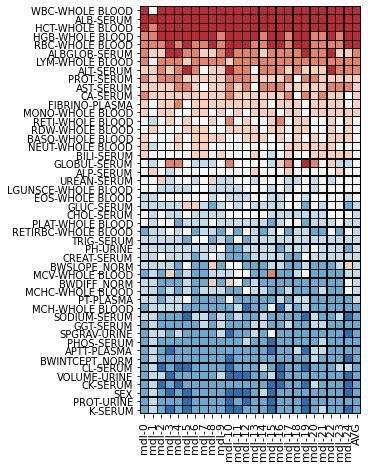

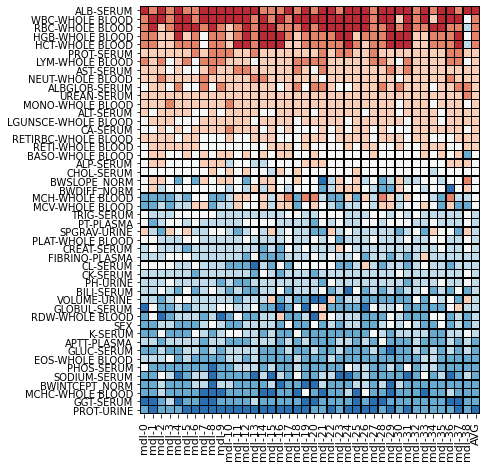

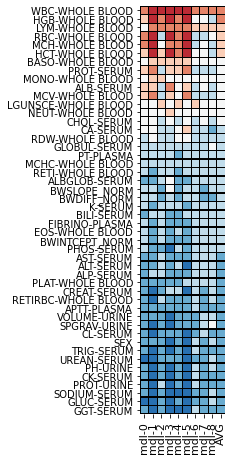

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns




diseases = ['NECROSIS', 'CHOLESTASIS', 'STEATOSIS']

for i, d_name in enumerate(diseases):
    
    fig, axarr = plt.subplots(figsize=(15, 7.5), ncols=1, nrows=1)
    df = residuals[d_name]
    df['AVG'] = df.mean(1)

    df.sort_values('AVG', inplace=True)
    sns.heatmap(df, cmap=sns.color_palette("RdBu", 7),
                cbar=False, square=True, linecolor='black', linewidths=0.25, ax=axarr, cbar_kws={"orientation": "horizontal"})

    axarr.set_yticks([x+0.5 for x in np.arange(len(df))])


    axarr.set_yticklabels(df.index, rotation=0, fontsize=10)
    
    axarr.set_xticks([x+0.5 for x in np.arange(len(df.columns))])
    axarr.set_xticklabels(df.columns, rotation=90, fontsize=11)
    
#     axarr[0].set_title(d_name.title(), fontsize=20)

    plt.savefig(f'data/{species}/figures/{d_name}/feature_heatmap_new_data.png', transparent=True)

In [68]:
df

,mdl-0,mdl-1,mdl-2,mdl-3,mdl-4,mdl-5,mdl-6,mdl-7,mdl-8,AVG
WBC-WHOLE BLOOD,0.010798,0.005593,0.007063,0.006200,0.005662,0.006627,0.009710,0.009029,0.009831,0.007835
HGB-WHOLE BLOOD,0.014488,0.005012,0.010511,0.004763,0.009934,0.004265,0.017234,0.016206,0.019451,0.011318
LYM-WHOLE BLOOD,0.015871,0.010316,0.010370,0.010551,0.010643,0.011094,0.013184,0.012842,0.013639,0.012057
RBC-WHOLE BLOOD,0.010303,0.003770,0.019852,0.004673,0.008229,0.003528,0.019560,0.020802,0.019149,0.012207
MCH-WHOLE BLOOD,0.008013,0.004199,0.016850,0.009864,0.009278,0.004232,0.021150,0.018458,0.020898,0.012549
HCT-WHOLE BLOOD,0.014155,0.006471,0.013406,0.006389,0.010317,0.006388,0.018619,0.018487,0.020179,0.012712
BASO-WHOLE BLOOD,0.016259,0.014311,0.013743,0.014786,0.013589,0.014811,0.017266,0.015844,0.017508,0.015346
PROT-SERUM,0.011616,0.009481,0.020787,0.012310,0.013920,0.009979,0.022703,0.019355,0.020288,0.015604
MONO-WHOLE BLOOD,0.017192,0.014588,0.014760,0.015270,0.015357,0.016134,0.015467,0.015797,0.016024,0.015621
ALB-SERUM,0.013242,0.012210,0.020211,0.010682,0.016592,0.011410,0.020838,0.018174,0.019924,0.015920


In [69]:
df = pd.read_csv(training_data_file, index_col=0)
df = df.replace(np.inf, np.nan)

/hive/Anaconda3-2020.02/envs/cheminformatics/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [70]:
min_response_value = 0.4

df = pd.read_csv(training_data_file, index_col=0)
df = df.replace(np.inf, np.nan)
srted_tests = df.notnull().sum().sort_values(ascending=False)

good_tests = df.columns[(df.notnull().sum() / df.shape[0]) > min_response_value]
good_tests = good_tests[~good_tests.isin(['USUBJID', 'STUDYID', 'SEX', 'STEATOSIS',
                                         'CHOLESTASIS', 'NECROSIS', 'SPECIES', 'IS_CONTROL',
                                         'BWDIFF', 'BWSLOPE', 'BWINTCEPT', 'MISTRESC'])]

data = df[good_tests]
data = data.apply(lambda x: x + abs(x.min()) + 1)
data = data.applymap(math.log10)


data.index = df.USUBJID
data['SEX'] = df['SEX']

le = LabelEncoder()
scaler = StandardScaler()


data['SEX'] = le.fit_transform(df['SEX'])

data = data.fillna(data.mean())
data = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

data.head()

,ALB-SERUM,ALBGLOB-SERUM,ALP-SERUM,ALT-SERUM,APTT-PLASMA,AST-SERUM,BASO-WHOLE BLOOD,BILI-SERUM,CA-SERUM,CHOL-SERUM,...,SODIUM-SERUM,SPGRAV-URINE,TRIG-SERUM,UREAN-SERUM,VOLUME-URINE,WBC-WHOLE BLOOD,BWDIFF_NORM,BWSLOPE_NORM,BWINTCEPT_NORM,SEX
USUBJID,,,,,,,,,,,,,,,,,,,,,
0436RA140_001-4201,0.202789,-0.116292,-0.498723,-0.454608,-2.829391e-15,-0.382498,0.814173,-0.243798,0.201633,-1.054498,...,0.312294,1.210959,-0.391369,0.231912,-4.671374e-16,0.787130,0.103419,0.144428,0.841787,0.977177
0436RA140_001-4202,-0.229870,-0.116292,-0.498723,-0.932984,-2.829391e-15,-0.733379,-0.824371,-0.438032,-0.884264,-0.615092,...,-0.309669,-0.052634,0.669787,-0.607666,-4.671374e-16,-0.343059,0.203184,0.188971,0.794798,0.977177
0436RA140_001-4203,0.629489,-0.116292,0.394745,-0.261184,-2.829391e-15,0.033222,0.553604,-0.056759,0.605093,0.045784,...,-0.309669,0.822733,0.255440,0.231912,-4.671374e-16,0.368605,-0.034567,-0.034770,-0.040090,0.977177
0436RA140_001-4204,-0.229870,-0.116292,0.444317,0.282846,-2.829391e-15,-0.130181,-0.824371,0.123598,-1.021038,0.203619,...,-0.933114,0.336737,-0.889860,-0.900309,-4.671374e-16,-0.189997,-0.160832,-0.165870,-1.526675,0.977177
0436RA140_001-4205,-0.229870,-0.116292,0.444317,-0.792194,-2.829391e-15,-0.048013,-0.412313,-0.243798,-1.240362,-0.572320,...,-0.309669,0.044757,0.436553,0.231912,-4.671374e-16,-1.150006,-0.110231,-0.092947,0.274589,0.977177


In [71]:
data.SEX

USUBJID
0436RA140_001-4201    0.977177
0436RA140_001-4202    0.977177
0436RA140_001-4203    0.977177
0436RA140_001-4204    0.977177
0436RA140_001-4205    0.977177
                        ...   
YV92WD-4637          -1.023356
YV92WD-4638          -1.023356
YV92WD-4639          -1.023356
YV92WD-4640          -1.023356
YV92WD-4641          -1.023356
Name: SEX, Length: 17285, dtype: float64

In [72]:
data['SEX'].mean()

1.0328253535419449e-16